In [1]:
# !pip install pyaml
# !pip install Shapely

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from copy import copy
import json as json
import yaml
from shapely.affinity import rotate, translate
from shapely.geometry import box

In [3]:
class Constraint(object):
  
  def __init__(self, layout):
    self.layout = layout
  
  def evaluate_cost(self):
    return 0
  
  def set_layout(self, layout):
    self.layout = layout
  
  def get_layout(self):
    return self.layout
  
  def get_layoutObject(self, index):
    return self.layout.getLayoutObjects()[index]
  
  def get_all_layoutObjects_by_indices(self, indicies):
    return [self.get_layoutObject(i) for i in indicies]
    
class AreaConstraint(Constraint):
  
  def __init__(self, layoutObjectIndicies, layout):
    self.layoutObjectIndicies = layoutObjectIndicies
    super().__init__(layout)
    
   #TODO: change to cascaded union
  def evaluate_cost(self):
    sumOfAreas = 0
    layoutObjects = self.get_all_layoutObjects_by_indices(self.layoutObjectIndicies)
    for i in range(len(layoutObjects)):
      for j in range(i + 1, len(layoutObjects)):
        sumOfAreas += layoutObjects[i].get_intersection(layoutObjects[j])
    return sumOfAreas

#Special constraint for plane checking
class BoundaryConstraint(Constraint):
  
  def __init__(self, layoutObjectIndicies, layout):
    self.layoutObjectIndicies = layoutObjectIndicies
    super().__init__(layout)
    
  def evaluate_cost(self):
    layoutObjects = self.get_all_layoutObjects_by_indices(self.layoutObjectIndicies)
    for layoutObject in layoutObjects:
      bbox = layoutObject.getPlane()
      if not(bbox.box.contains(layoutObject.box)):
        return float("inf")
    return 0

class FacingConstraint(Constraint):
  
  def __init__(self, layoutObjectIndicies, toFaceIndicies, layout):
    self.layoutObjectIndicies = layoutObjectIndicies
    self.toFaceIndicies = toFaceIndicies
    super().__init__(layout)
    
  def evaluate_cost(self):
    cost = 0
    layoutObjects = self.get_all_layoutObjects_by_indices(self.layoutObjectIndicies)
    facingObjects = self.get_all_layoutObjects_by_indices(self.toFaceIndicies)
    for layoutObj in layoutObjects:
      min_angle = float('inf')
      for candidate in facingObjects:
        candidate_angle = layoutObj.get_angle_to_other_object(candidate)
        min_angle = min(min_angle, layoutObj.get_angle_to_other_object(candidate))
      cost += min_angle
    
    return 1/(len(layoutObjects)) * cost # average angle cost

  
class DirectionConstraint(Constraint):
  #direciton is a tuple
  def __init__(self, layoutObjectIndicies, direction, layout):
    self.layoutObjectIndicies = layoutObjectIndicies
    self._direction = direction
    super().__init__(layout)

  def evaluate_cost(self):
    cost = 0
    layoutObjects = self.get_all_layoutObjects_by_indices(self.layoutObjectIndicies)
    for layoutObject in layoutObjects:
      cost += layoutObject.get_angle_to_direction(self._direction)
    return cost / len(layoutObjects)
  

#on_type in YAML
class SemanticConstraint(Constraint):
  
  #weight should factor in hyperparameter
  def __init__(self, layoutObjectIndicies, classToBind, weight, layout):
    self.layoutObjectIndicies = layoutObjectIndicies
    self.desiredClass = classToBind
    self.weight = weight
    super().__init__(layout)

  def evaluate_cost(self):
    cost = 0
    layoutObjects = self.get_all_layoutObjects_by_indices(self.layoutObjectIndicies)
    for layoutObject in layoutObjects:
      if layoutObject.getPlane().get_class() != self.desiredClass:
        cost += self.weight
    return cost

In [4]:
class Rectangle(object):
  
  def __init__(self, center=None, dim1=None, dim2=None, _targetBox=None, _targetPaddedBox=None, className=None):
    """
    center: (x, y)
    dim1 = x dimension
    dim2 = y dimension 
    """
    padding = self.get_padding()
    
    if(_targetBox != None):
      self.box = _targetBox
      assert _targetPaddedBox != None
      self.padded_box = _targetPaddedBox
    else:
      center_x = center[0]
      center_y = center[1]
      self.box = box(center_x - dim1/2., center_y - dim2/2., center_x + dim1/2., center_y + dim2/2.)
      self.padded_box = box(center_x - dim1/2., center_y - dim2/2., center_x + dim1/2., center_y + dim2/2.)
#       if rot != 0:
#         self.box = rotate(self.box, rot, origin='center', use_radians=False)
#         self.padded_box = rotate(self.padded_box, rot, origin='center', use_radians=False)
    self._myPlane = None
    if className == None:
      self.className = "default"
    else:
      self.className = className
  
  def get_padding(self):
    return (0, 0, 0, 0) #left, right, top, bottom
  
  def set_padding(self, padding):
    center_x, center_y = self.center
    bounds = self.box.bounds # minx, miny, maxx, maxy
    self.padded_box = box(bounds[0] - padding[0], bounds[1] - padding[3], bounds[2] + padding[1], bounds[3] + padding[2])
  
  def get_class(self):
    return self.className
  
  def update_center(self, center):
    """
    Moves the rectangle to a new center (tuple/array) while maintaining current rotation. 
    """
    bounds = self.box.bounds
    center_x = (bounds[0] + bounds[2]) / 2. 
    center_y = (bounds[1] + bounds[3]) / 2. 
    displace_x = center[0] - center_x
    displace_y = center[1] - center_y 
    self.box = translate(self.box, displace_x, displace_y)
    self.padded_box = translate(self.padded_box, displace_x, displace_y)
    
  def get_translated(self, xoff=0.0, yoff=0.0, zoff=0.0):
    new_box = translate(self.box, xoff, yoff, zoff)
    new_padded = translate(self.padded_box, xoff, yoff, zoff)
    newRect = Rectangle(_targetBox=new_box, _targetPaddedBox=new_padded)
    newRect.className = self.className
    return newRect
 
  def get_rotated(self, angle):
    new_box = rotate(self.box, angle, origin='center', use_radians=False)
    new_padded = rotate(self.padded_box, angle, origin='center', use_radians=False)
    newRect = Rectangle(_targetBox=new_box, _targetPaddedBox=new_padded)
    newRect.className = self.className
    return newRect
  
  def get_intersection(self, rect2):
    intersection = self.padded_box.intersection(rect2.padded_box)
    return intersection.area
  
  def get_area(self):
    return self.box.area

  def get_dimensions(self):
    minx, miny, maxx, maxy = self.padded_box.bounds
    return abs(maxx - minx), abs(maxy - miny)
    
  @property
  def center(self):
    bounds = self.box.bounds
    center_x = (bounds[0] + bounds[2]) / 2. 
    center_y = (bounds[1] + bounds[3]) / 2. 
    return (center_x, center_y)    
  
  def get_angle_to_other_object(self, rect2):
    """
    Returns angle (0 to 180) between left side of current object and
    center of rect2
    """
    top_left = np.array(self.box.exterior.coords[2])
    bottom_left = np.array(self.box.exterior.coords[3])
        
    vector1 = top_left - bottom_left
    vector2 = np.array(rect2.center) - np.array(self.center)
    angle = Rectangle.get_angle(vector1, vector2)
    return angle
  
  def get_angle_to_direction(self, direction):
    top_left = np.array(self.box.exterior.coords[2])
    bottom_left = np.array(self.box.exterior.coords[3])
    vector1 = top_left - bottom_left

    return Rectangle.get_angle(vector1, np.array(direction))
  
  
  @staticmethod
  def get_angle(vector1, vector2): 
    # vector1, vector2 are np arrays, returns in degrees
    dot_product = np.dot(vector1, vector2)
    norma = np.dot(vector1, vector1)
    normb = np.dot(vector2, vector2)
    return np.arccos(dot_product / (norma * normb)**(1./2)) * (180/np.pi)    
  
  def setPlane(self, plane):
    self._myPlane = plane

  def getPlane(self):
    return self._myPlane
  
  def fromObjRepr(stringRepr):
    # example: {"center":{"x":-10.8100004196167,"y":0.0},"dim1":0.9999999403953552,
    # "dim2":0.9999999403953552,"rotation":19.999998092651368,"className":""}
    center = (stringRepr['center']['x'], stringRepr['center']['y'])
    newRect = Rectangle(center, stringRepr['dim1'], stringRepr['dim2'])
    if stringRepr['className'] != "" and stringRepr['className'] != None:
      newRect.className = stringRepr['className']
    return newRect.get_rotated(stringRepr['rotation'])
  
  def toObjRepr(self):
    objRepr = {}
    #Just center for now
    center = {}
    bounds = self.box.bounds
    center_x = (bounds[0] + bounds[2]) / 2. 
    center_y = (bounds[1] + bounds[3]) / 2. 
    center['x'] = center_x
    center['y'] = center_y
    objRepr['center'] = center
    return objRepr
  
class Layout(object):
  
  def __init__(self, layoutObjects, planeBoxes, doAssignment=False):
    self._myLayoutObjects = layoutObjects
    self.planeBoxes = planeBoxes
    self._myConstraints = []
    if doAssignment:
      self._assignBoxes()
    
  def _assignBoxes(self):
    for layoutObj in self._myLayoutObjects:
#       objArea = layoutObj.get_area()
      indexes = np.arange(len(self.getPlaneBoxes()))
      np.random.shuffle(indexes)
      for j in indexes:
        candidatePlane = self.planeBoxes[j]
#         if objArea < candidatePlane.get_area():
        candidate_x, candidate_y = candidatePlane.get_dimensions()
        obj_x, obj_y = layoutObj.get_dimensions()
        if obj_x < candidate_x and obj_y < candidate_y:
          layoutObj.setPlane(candidatePlane)
          layoutObj.update_center(candidatePlane.center)
          break

      
  def getLayoutObjects(self):
    return self._myLayoutObjects
  
  def getPlaneBoxes(self):
    return self.planeBoxes
  
  def getClassToObjects(self):
    classToObj = {}
    for layoutObject in self._myLayoutObjects:
      className = layoutObject.get_class()
      if className not in classToObj:
        classToObj[className] = []
      classToObj[className].append(layoutObject)
    return classToObj
  
  def addConstraint(self, constraint):
    self._myConstraints.append(constraint)
  
  def getConstraints(self):
    return self._myConstraints
  
  def drawLayout(self):
    plt.axes()
    x = np.arange(len(self._myLayoutObjects))
    ys = [i+x+(i*x)**2 for i in range(len(self._myLayoutObjects))]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    #For now all layout objects are Boxes
    i = 0
    for box in self._myLayoutObjects:
      shape = plt.Polygon(np.array(box.box.exterior.coords), fc=colors[i])
      plt.gca().add_patch(shape)
      #label the box
      plt.text(box.center[0], box.center[1], str(i))
      i += 1
    #bounding box
    for planeBox in self.getPlaneBoxes():
      shape = plt.Polygon(np.array(planeBox.box.exterior.coords), fc="c", alpha=0.1)
      plt.gca().add_patch(shape)
    plt.axis('scaled')
    plt.show()
   
  def __copy__(self):
    newLayoutObjects = []
    for layoutObject in self.getLayoutObjects():
      newLayoutObject = copy(layoutObject)
      newLayoutObjects.append(newLayoutObject)
    return Layout(*newLayoutObjects) 



In [5]:
def parse_constraint_yaml(file_name):
  with open(file_name, 'r') as layoutdef:
    data = layoutdef.read()
    parsed = yaml.load(data)
    return parsed['classes']
  
def get_attributes_for_class(class_name, constraint_def):
  for class_def in constraint_def:
    dotted_name = '.' + class_name 
    if dotted_name in class_def:
      return class_def[dotted_name]
    
def create_constraints_from_yaml(file_name, layout):
  constraint_def = parse_constraint_yaml(file_name)
  classNameToLayoutObjects = layout.getClassToObjects()
  for className in classNameToLayoutObjects:
    attrs = get_attributes_for_class(className, constraint_def)
    if attrs == None:
      continue
    layoutObjects = classNameToLayoutObjects[className]
    for attr in attrs:
      dispatch_attribute(attr, layoutObjects, layout)
  #add the two default constraints
  allObjectIndicies = list(range(len(layout.getLayoutObjects())))
  layout.addConstraint(BoundaryConstraint(allObjectIndicies, layout))
  layout.addConstraint(AreaConstraint(allObjectIndicies, layout))
     
def get_inidices_list_for_layoutObjects(subset_layoutObject, layout):
  all_layoutObjects = layout.getLayoutObjects()
  ans = [all_layoutObjects.index(obj) for obj in subset_layoutObject]
  return ans
    
def dispatch_attribute(attr, layoutObjects, layout):
  attrName = list(attr.keys())[0]
  if attrName == 'padding':
    handle_padding(layoutObjects, attr['padding'])
  if attrName == 'facing':
    handle_facing(layoutObjects, attr['facing'][1:], layout)
  if attrName == 'direction':
    handle_direction(layoutObjects, attr['direction'])
  if attrName == 'binding':
    handle_binding(layoutObjects, attr['binding'], layout)

def handle_padding(layoutObjects, paddingString):
  padding = [float(x) for x in paddingString.split(',')] #LRTB
  for layoutObject in layoutObjects:
    layoutObject.set_padding(padding)
  
def handle_facing(layoutObjects, facingClass, layout):
    classNameToLayoutObjects = layout.getClassToObjects()
    if facingClass not in classNameToLayoutObjects:
      return
    facingObjects = classNameToLayoutObjects[facingClass]
    constraint = FacingConstraint(get_inidices_list_for_layoutObjects(layoutObjects, layout), 
                                  get_inidices_list_for_layoutObjects(facingObjects, layout),
                                  layout)
    layout.addConstraint(constraint)
    
def handle_direction(layoutObjects, directionString):
  directionTuple = tuple([float(x) for x in directionString[1:-1].split(',')]) #<X, Y>
  constraint = DirectionConstraint(get_inidices_list_for_layoutObjects(layoutObjects, layout), 
                                   directionTuple,
                                   layout)
  layout.addConstraint(constraint)
  
def handle_binding(layoutObjects, bindingString, layout):
  indices = get_inidices_list_for_layoutObjects(layoutObjects, layout)
  assert bindingString[0] == '$'
  className = bindingString[1:]
  constraint = SemanticConstraint(indices, className, 1, layout)
  layout.addConstraint(constraint)

b  =  Rectangle((0, 0), 0.7, 0.04, className="test1")
b2 = Rectangle((0, 0),  4, 3.1, className="test1")
b3 = Rectangle((0, 0),  0.5, 0.5, className="test2")
# b4 = Rectangle((0, 0),  0.75, 0.5, className="test1")
# b5 = Rectangle((0, 0),  1.2, 1.5, className="test1")
# b6 = Rectangle((0, 0),  0.5, 0.5, className="test2")
# b7 = Rectangle((0, 0),  0.5, 0.5, className="test1")
# b7 = Rectangle((0, 0),  0.85, 2, className="test1")

bounds = Rectangle((0, 0),  5, 5)
bounds2 = Rectangle((10, 2), 7, 5)
layout = Layout([b, b2, b3], [bounds], doAssignment=True)

create_constraints_from_yaml('test.yaml', layout)
  

In [12]:
def boltzmann(cost, beta=1.0):
  return np.exp(-beta*cost)

def acceptanceProbability(current_cost, proposed_cost):
  return min(1, boltzmann(proposed_cost)/boltzmann(current_cost))


def get_cost(layout, constraints):
  layoutObjects = layout.getLayoutObjects()
  cost = 0

  for constraint in constraints:
    constraint.set_layout(layout)
    new_cost = constraint.evaluate_cost()
    cost += new_cost

  return cost


def propose_new_layout(current_layout, prob_swap_plane, perturb, rotate_perturb):
  new_layout_objects = []
  planeBoxes = current_layout.getPlaneBoxes()
  layout_objects = current_layout.getLayoutObjects() 
  rotate_index = np.random.randint(len(layout_objects))
  to_rotate = layout_objects[rotate_index]
  
  for i in range(len(layout_objects)):
    rect = layout_objects[i]
    rect_center = rect.center 
    new_rect = rect.get_translated(np.random.normal(scale=perturb), np.random.normal(scale=perturb))
    if i == rotate_index:
        new_rect = new_rect.get_rotated(np.random.normal(scale=rotate_perturb))
     
    new_rect.setPlane(rect.getPlane())
    new_layout_objects.append(new_rect)
  
  if np.random.random() < prob_swap_plane: 
    randomObject = new_layout_objects[np.random.randint(len(new_layout_objects))]
    randomPlane = planeBoxes[np.random.randint(len(planeBoxes))]
    randomObject.setPlane(randomPlane)
    randomObject.update_center(randomPlane.center)
    
  new_layout = Layout(new_layout_objects, planeBoxes)
  return new_layout

def metropolis_hastings(initial_layout, num_iters=10000, prob_swap_plane=0.1, perturb=0.1, rotate_perturb=10):
  cur_cost = get_cost(initial_layout, initial_layout.getConstraints())
  cur_layout = initial_layout
  best_layout = cur_layout
  best_cost = cur_cost
  
  for i in range(num_iters):
        
    print("Before")
    cur_layout.drawLayout()
    new_layout = propose_new_layout(cur_layout, prob_swap_plane, perturb, rotate_perturb)
    print("After")
    cur_layout.drawLayout()
    print("New layout")
    new_layout.drawLayout()
    new_cost = get_cost(new_layout, initial_layout.getConstraints())
    
    if i % 1000 == 0:
        print("iter: ", i)
    
    if np.random.random() < acceptanceProbability(cur_cost, new_cost):
#       print(cur_cost)
#       print(new_cost)
#       print(acceptanceProbability(cur_cost, new_cost))
      cur_layout = new_layout
      cur_cost = new_cost
      cur_layout.drawLayout()
      if cur_cost < best_cost:
        best_layout = cur_layout
        best_cost = cur_cost
      
  return best_layout

# b  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
# b3  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
# b4  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
# b5  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
# b6  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
# b7  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
# b2  =  Rectangle((0, 0), 1.5, 1.5, className="test2")
# table = Rectangle((0, 0),  3, 3)
# couch = Rectangle((3.25, 0.5),  1, 2.5, className="couch")
# couch2 = Rectangle((3.25, -2.1), 1, 2.5, className="couch")
# couch3 = Rectangle((-1, -3), 2.5, 1, className="couch")
# layout = Layout([b, b2, b3, b4, b5, b6, b7], [table, couch, couch2, couch3], doAssignment=True)
# layout.drawLayout()

# create_constraints_from_yaml('test.yaml', layout)
  
# final_layout = metropolis_hastings(layout, num_iters=100)
# final_layout.drawLayout()

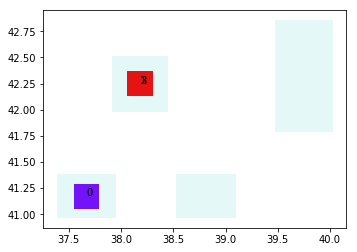

Before


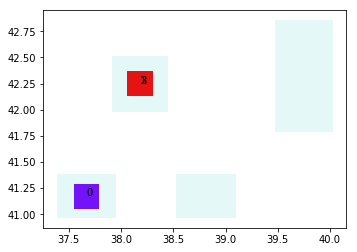

After


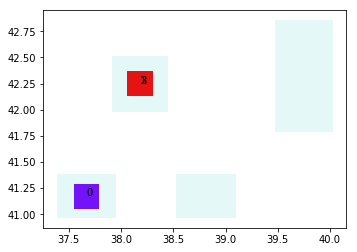

New layout


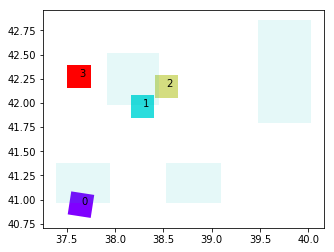

iter:  0
Before


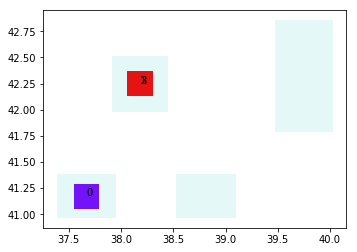

After


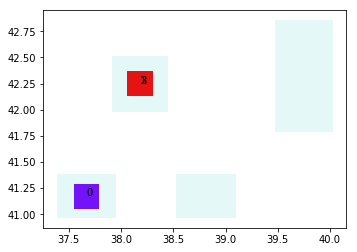

New layout


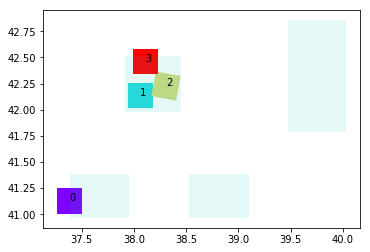

Before


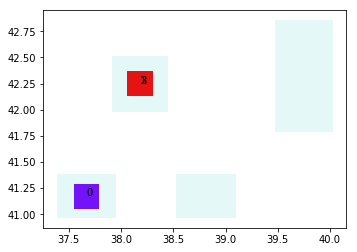

After


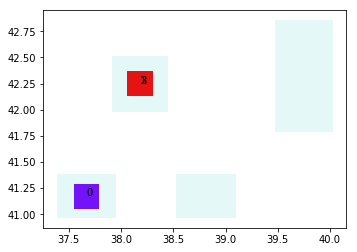

New layout


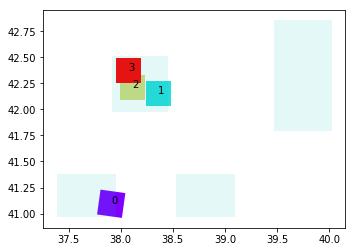

Before


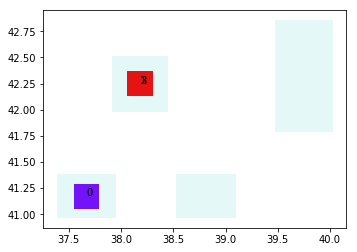

After


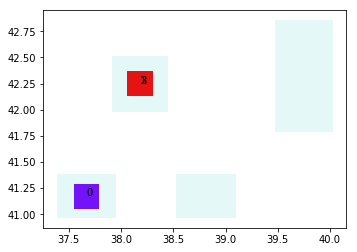

New layout


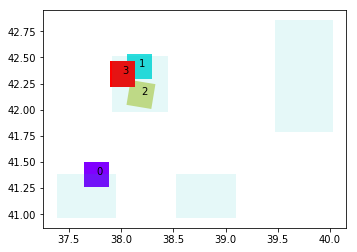

Before


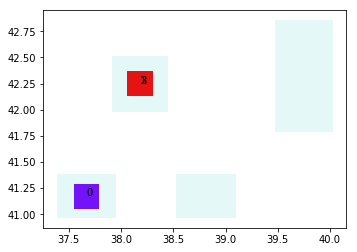

After


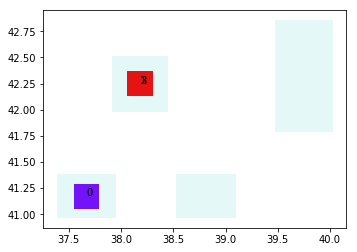

New layout


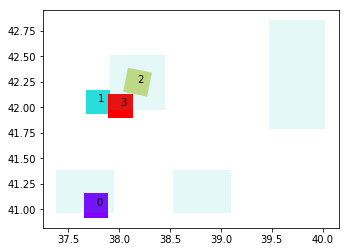

Before


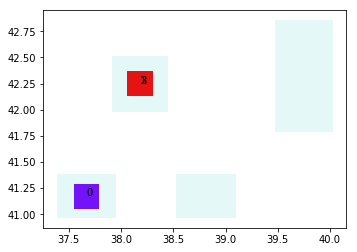

After


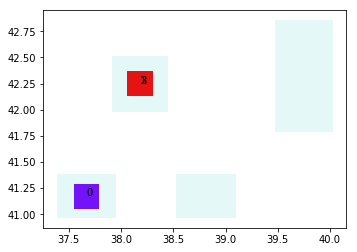

New layout


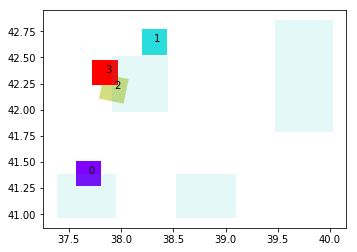

Before


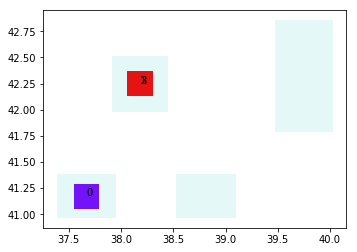

After


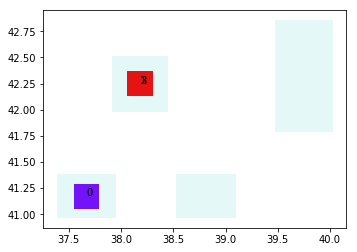

New layout


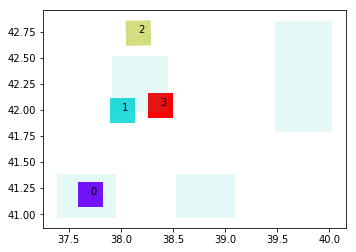

Before


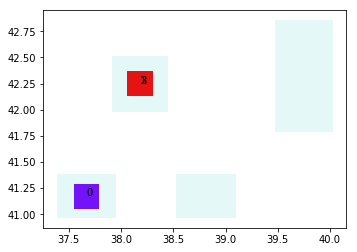

After


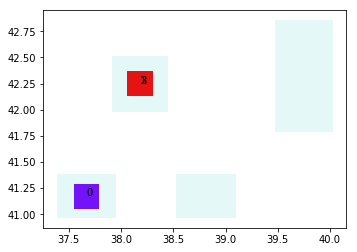

New layout


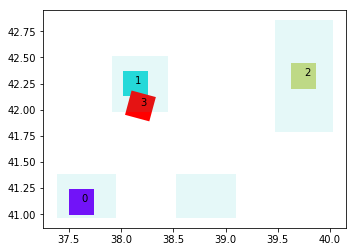

Before


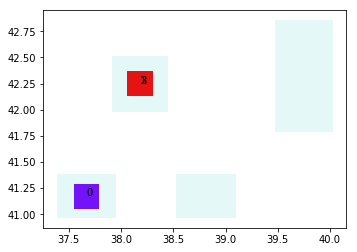

After


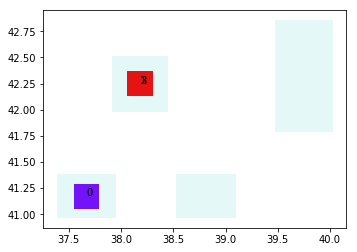

New layout


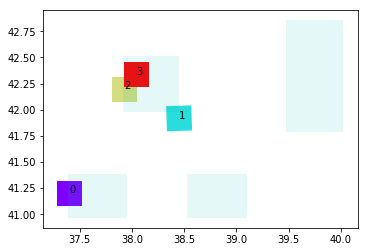

Before


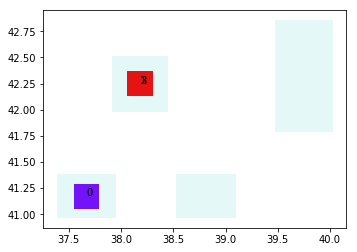

After


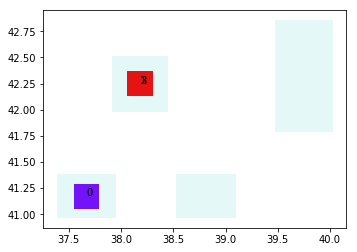

New layout


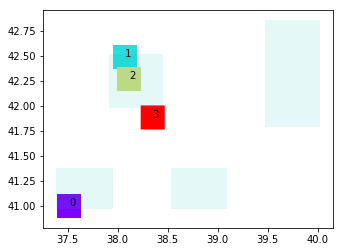

Before


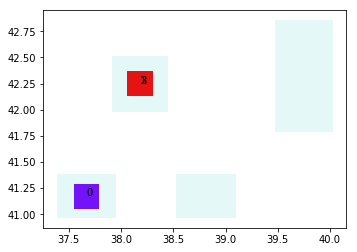

After


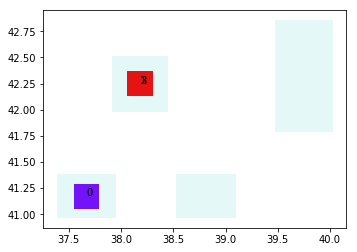

New layout


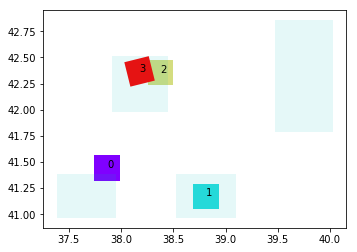

Before


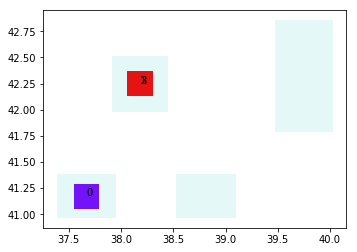

After


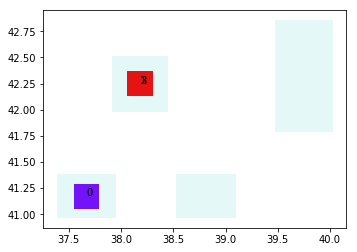

New layout


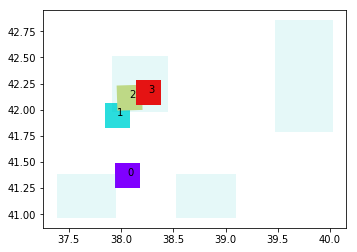

Before


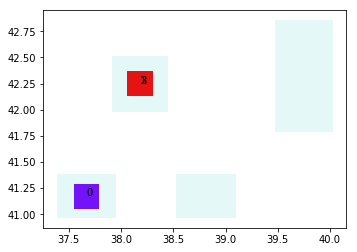

After


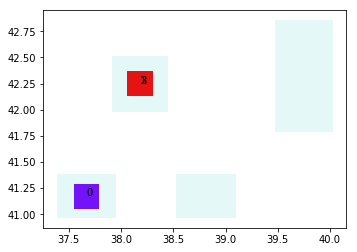

New layout


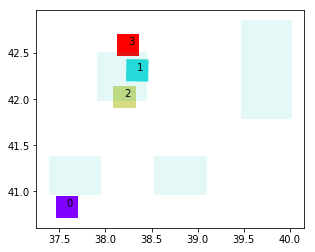

Before


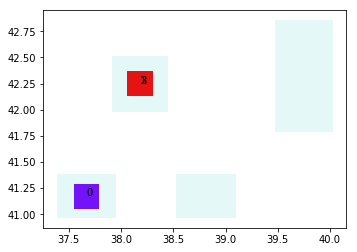

After


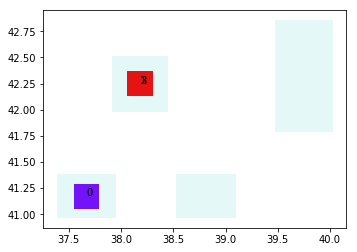

New layout


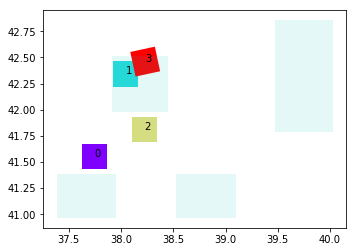

Before


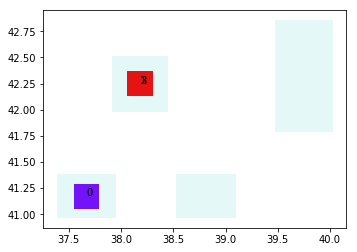

After


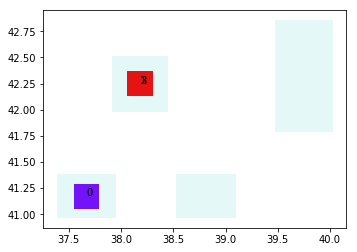

New layout


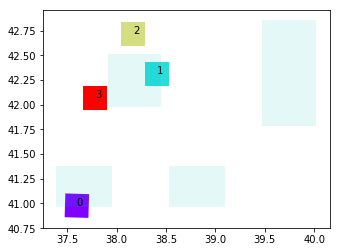

Before


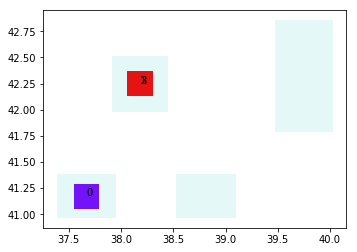

After


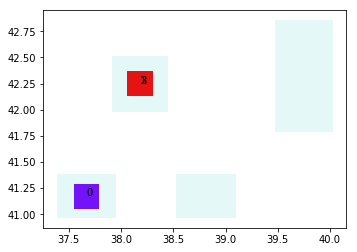

New layout


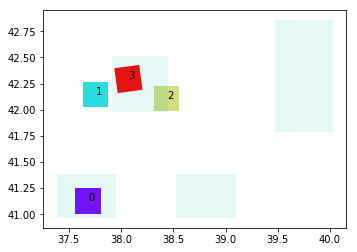

Before


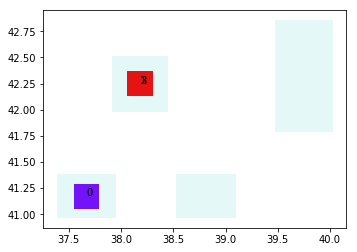

After


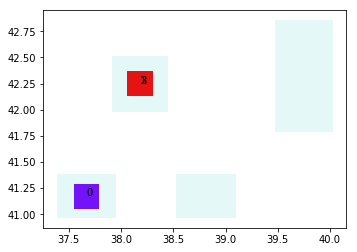

New layout


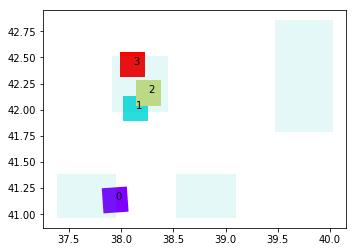

Before


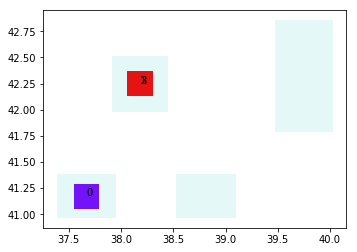

After


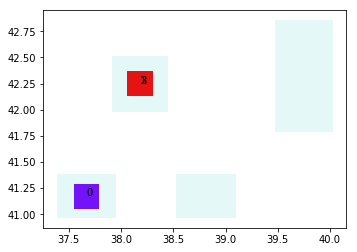

New layout


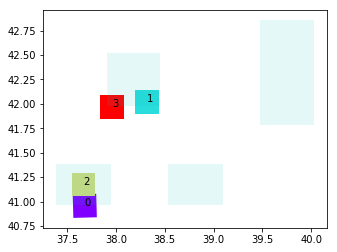

Before


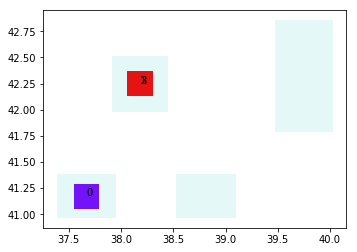

After


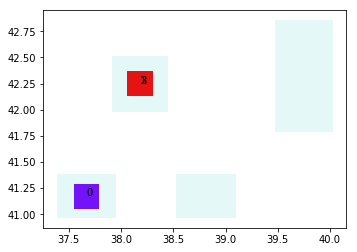

New layout


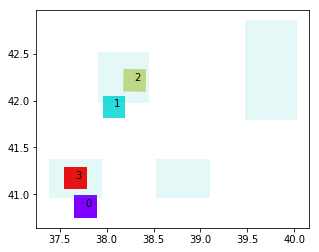

Before


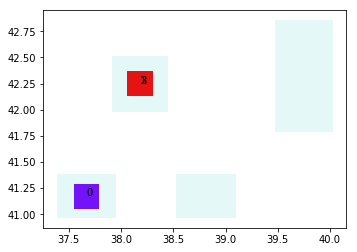

After


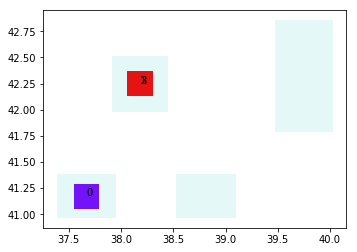

New layout


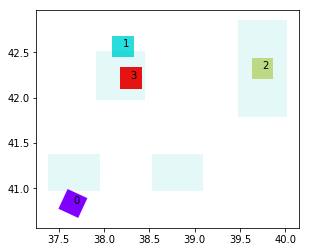

Before


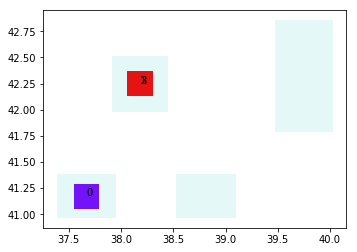

After


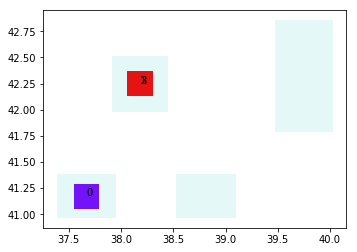

New layout


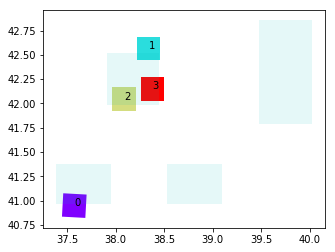

Before


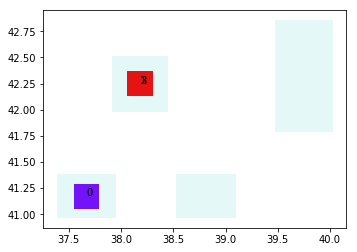

After


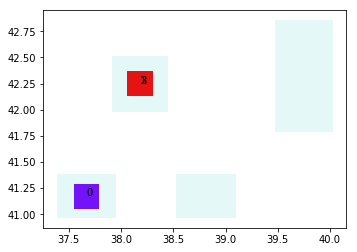

New layout


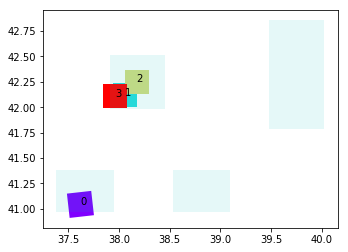

Before


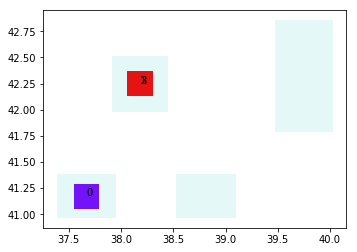

After


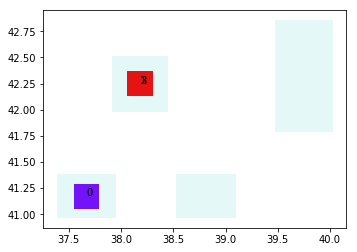

New layout


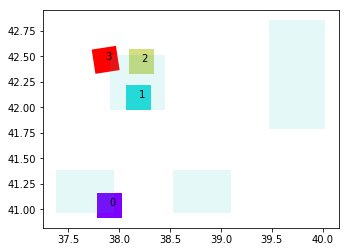

Before


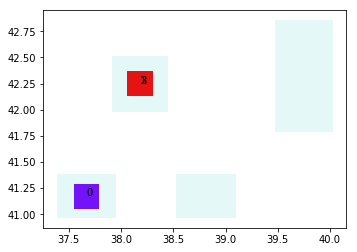

After


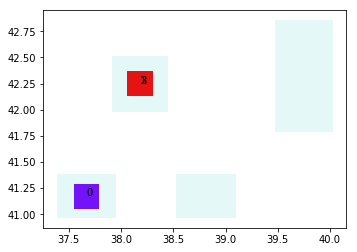

New layout


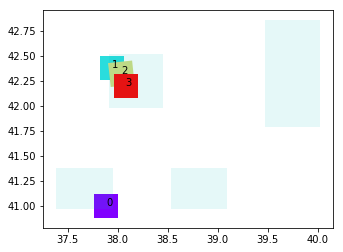

Before


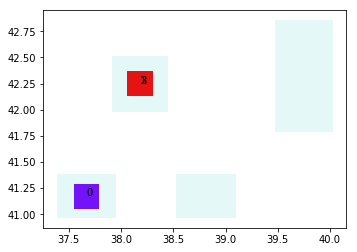

After


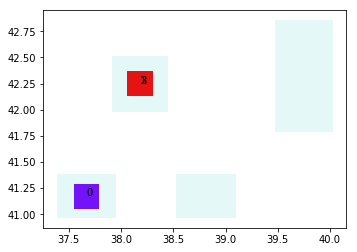

New layout


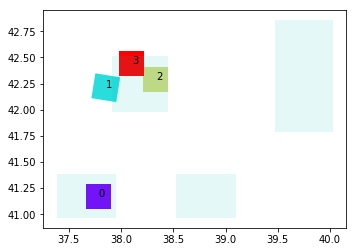

Before


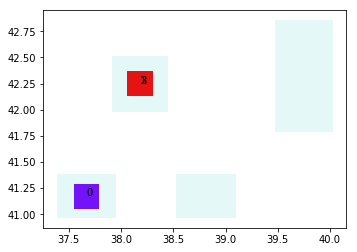

After


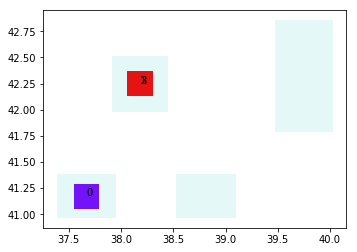

New layout


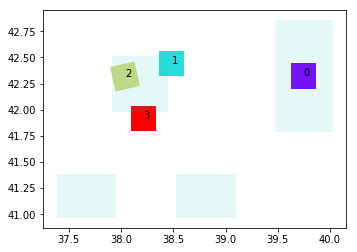

Before


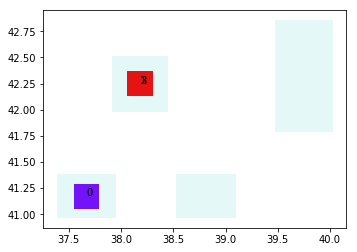

After


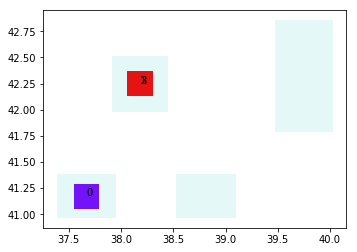

New layout


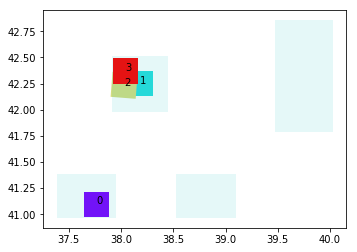

Before


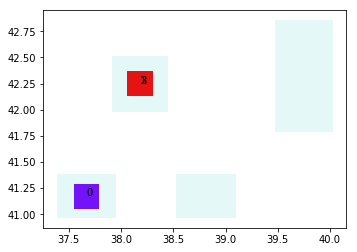

After


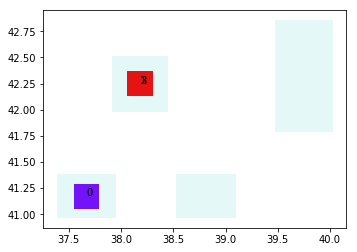

New layout


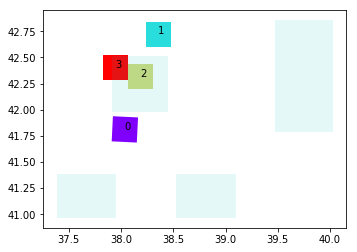

Before


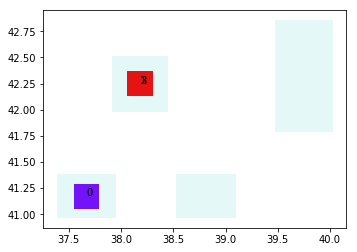

After


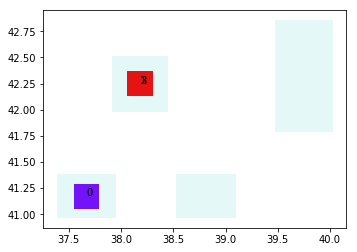

New layout


KeyboardInterrupt: 

In [13]:
#Test from Json
layoutObjsString = '{"planeBoxes":[{"center":{"x":39.749000549316409,"y":42.321998596191409},"dim1":0.5497268438339233,"dim2":1.0673162937164307,"rotation":0.0,"className":"Sittable"},{"center":{"x":38.18199920654297,"y":42.24800109863281},"dim1":0.5400000214576721,"dim2":0.5375000238418579,"rotation":0.0,"className":"Table"},{"center":{"x":37.667999267578128,"y":41.17300033569336},"dim1":0.5672000050544739,"dim2":0.41659995913505556,"rotation":0.0,"className":"Sittable"},{"center":{"x":38.8129997253418,"y":41.17300033569336},"dim1":0.5672000050544739,"dim2":0.41659995913505556,"rotation":0.0,"className":"Sittable"}],"layoutObjects":[{"center":{"x":38.111000061035159,"y":42.25},"dim1":0.24061492085456849,"dim2":0.24061492085456849,"rotation":0.0,"className":"item"},{"center":{"x":38.111000061035159,"y":42.25},"dim1":0.24061492085456849,"dim2":0.24061492085456849,"rotation":0.0,"className":"person"},{"center":{"x":38.111000061035159,"y":42.25},"dim1":0.24061492085456849,"dim2":0.24061492085456849,"rotation":0.0,"className":"person"},{"center":{"x":38.111000061035159,"y":42.25},"dim1":0.24061492085456849,"dim2":0.24061492085456849,"rotation":0.0,"className":"person"}]}'
layoutObj = eval(layoutObjsString)
planeBoxes = []

rectObjs = layoutObj['planeBoxes']
for rectObj in rectObjs:
  rect = Rectangle.fromObjRepr(rectObj)
  planeBoxes.append(rect)
  
layoutObjs = []
rectObjs = layoutObj['layoutObjects']
for rectObj in rectObjs:
  rect = Rectangle.fromObjRepr(rectObj)
  layoutObjs.append(rect)

    
layout = Layout(layoutObjs, planeBoxes, doAssignment=True)
layout.drawLayout()
create_constraints_from_yaml('test.yaml', layout)
constraints = layout.getConstraints()
cost = get_cost(layout, constraints)
while cost == float("inf"):
    layout = Layout(layoutObjs, planeBoxes, doAssignment=True)
    layout._myConstraints = constraints
    cost = get_cost(layout, constraints)

# print(layout.getConstraints())
  
final_layout = metropolis_hastings(layout, num_iters=10000, perturb=0.2, prob_swap_plane=0.3)
final_layout.drawLayout()

#Test to json
allRects = final_layout.getLayoutObjects()
output = {}
results = []
output['layoutObjects'] = results
for rect in allRects:
  results.append(rect.toObjRepr())
jsonstr = json.dumps(output)
a = jsonstr.replace('"', '\\"').replace('\n', '\\n')  
print(a)

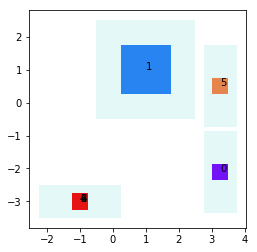

total constraints: [<__main__.FacingConstraint object at 0x11b910198>, <__main__.SemanticConstraint object at 0x1198e7d68>, <__main__.DirectionConstraint object at 0x11ba85588>, <__main__.BoundaryConstraint object at 0x11b9ee940>, <__main__.AreaConstraint object at 0x11ba85550>]
COST:  128.11729734140755


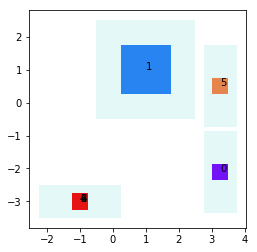

iter:  0
iter:  1000
iter:  2000
iter:  3000
iter:  4000
iter:  5000


KeyboardInterrupt: 

In [8]:
b  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
b3  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
b4  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
b5  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
b6  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
b7  =  Rectangle((0, 0), 0.5, 0.5, className="test1")
b2  =  Rectangle((0, 0), 1.5, 1.5, className="test2")
table = Rectangle((1, 1),  3, 3)
couch = Rectangle((3.25, 0.5),  1, 2.5, className="couch")
couch2 = Rectangle((3.25, -2.1), 1, 2.5, className="couch")
couch3 = Rectangle((-1, -3), 2.5, 1, className="couch")
layout = Layout([b, b2, b3, b4, b5, b6, b7], [table, couch, couch2, couch3], doAssignment=True)
layout.drawLayout()

create_constraints_from_yaml('test_working.yaml', layout)
  
constraints = layout.getConstraints()


print("total constraints:", constraints)
cost = get_cost(layout, constraints)
layoutObjs = layout.getLayoutObjects()
planeBoxes = layout.getPlaneBoxes()

print("COST: ", cost)

# while cost == float("inf"):
#     layout = Layout(layoutObjs, planeBoxes, doAssignment=True)
#     layout._myConstraints = constraints
#     cost = get_cost(layout, constraints)
    
layout.drawLayout()

    
final_layout = metropolis_hastings(layout, num_iters=100000)
final_layout.drawLayout()